# 1. Importing the dependencies

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

# 2. Custom Random Forest Algorithm

In [49]:
# Simplified Decision Tree implementation
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            
    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = self._grow_tree(X, y)
        
    def _gini(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in range(self.n_classes))
    
    def _best_split(self, X, y):
        m, n = X.shape
        if m <= self.min_samples_split:
            return None, None
            
        best_gini = self._gini(y)
        best_feat, best_thresh = None, None
        
        for feat in range(n):
            thresholds = np.unique(X[:, feat])
            for thresh in thresholds:
                left_idx = X[:, feat] <= thresh
                if np.sum(left_idx) == 0 or np.sum(left_idx) == m:
                    continue
                gini = (self._gini(y[left_idx]) * np.sum(left_idx) +
                        self._gini(y[~left_idx]) * np.sum(~left_idx)) / m
                if gini < best_gini:
                    best_gini = gini
                    best_feat = feat
                    best_thresh = thresh
                    
        return best_feat, best_thresh
    
    def _grow_tree(self, X, y, depth=0):
        if self.max_depth and depth >= self.max_depth:
            return self.Node(value=np.argmax(np.bincount(y)))
            
        feat, thresh = self._best_split(X, y)
        if feat is None:
            return self.Node(value=np.argmax(np.bincount(y)))
            
        left_idx = X[:, feat] <= thresh
        right_idx = ~left_idx
        left = self._grow_tree(X[left_idx], y[left_idx], depth+1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth+1)
        return self.Node(feat, thresh, left, right)
        
    def predict(self, X):
        return [self._predict(x) for x in X]
    
    def _predict(self, x, node=None):
        if node is None:
            node = self.tree
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict(x, node.left)
        else:
            return self._predict(x, node.right)

In [50]:
import numpy as np

class RandomForest:
    def __init__(self, n_trees=50, max_depth=10, min_samples_split=2, 
                 sample_ratio=0.8, feat_ratio=0.6, random_state=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.sample_ratio = sample_ratio
        self.feat_ratio = feat_ratio
        self.random_state = random_state  # Ensure reproducibility
        self.trees = []
        
    def fit(self, X, y):
        if self.random_state is not None:
            np.random.seed(self.random_state)  # Fix seed for consistent results
        
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        for i in range(self.n_trees):
            # Bootstrap sampling
            sample_idx = np.random.choice(n_samples, int(n_samples * self.sample_ratio), replace=True)
            feat_idx = np.random.choice(n_features, int(n_features * self.feat_ratio), replace=False)
            
            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X[sample_idx][:, feat_idx], y[sample_idx])
            self.trees.append((tree, feat_idx))
            
    def predict(self, X):
        all_preds = np.zeros((X.shape[0], self.n_trees))
        for i, (tree, feat_idx) in enumerate(self.trees):
            all_preds[:, i] = tree.predict(X[:, feat_idx])
        
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), 1, all_preds)

# 3. Data Loading & Understanding

In [52]:
df = pd.read_csv("train.csv")

In [53]:
df.shape

(800, 22)

In [54]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [56]:
# converting age column datatype to integer
df['age'] = df['age'].astype(int)

In [57]:
df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [58]:
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("-"*80)

A1_Score [1 0]
--------------------------------------------------------------------------------
A2_Score [0 1]
--------------------------------------------------------------------------------
A3_Score [1 0]
--------------------------------------------------------------------------------
A4_Score [0 1]
--------------------------------------------------------------------------------
A5_Score [1 0]
--------------------------------------------------------------------------------
A6_Score [0 1]
--------------------------------------------------------------------------------
A7_Score [1 0]
--------------------------------------------------------------------------------
A8_Score [0 1]
--------------------------------------------------------------------------------
A9_Score [1 0]
--------------------------------------------------------------------------------
A10_Score [1 0]
--------------------------------------------------------------------------------
gender ['f' 'm']
----------------------

In [59]:
# dropping ID and age_desc column
df = df.drop(columns=['ID','age_desc'])

In [60]:
df.shape

(800, 20)

In [61]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,?,no,no,South Africa,no,-4.777286,Self,0


In [62]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [63]:
df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Viet Nam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'AmericanSamoa', 'Bahamas', 'Saudi Arabia',
       'Ireland', 'Aruba', 'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan',
       'Armenia', 'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'Hong Kong',
       'Angola', 'China', 'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran',
       'Argentina', 'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone',
       'Czech Republic', 'Niger', 'Romania', 'Cyprus', 'Belgium',
       'Burundi', 'Bangladesh'], dtype=object)

In [64]:
# defining mapping dictionary for country names
mapping = {
    "Viet Nam":"Vietnam",
    "AmericanSamoa":"United States",
    "Hong Kong":"China"
}

# replacing values in the country column
df['contry_of_res'] = df['contry_of_res'].replace(mapping)

In [65]:
df['contry_of_res'].unique()

array(['Austria', 'India', 'United States', 'South Africa', 'Jordan',
       'United Kingdom', 'Brazil', 'New Zealand', 'Canada', 'Kazakhstan',
       'United Arab Emirates', 'Australia', 'Ukraine', 'Iraq', 'France',
       'Malaysia', 'Vietnam', 'Egypt', 'Netherlands', 'Afghanistan',
       'Oman', 'Italy', 'Bahamas', 'Saudi Arabia', 'Ireland', 'Aruba',
       'Sri Lanka', 'Russia', 'Bolivia', 'Azerbaijan', 'Armenia',
       'Serbia', 'Ethiopia', 'Sweden', 'Iceland', 'China', 'Angola',
       'Germany', 'Spain', 'Tonga', 'Pakistan', 'Iran', 'Argentina',
       'Japan', 'Mexico', 'Nicaragua', 'Sierra Leone', 'Czech Republic',
       'Niger', 'Romania', 'Cyprus', 'Belgium', 'Burundi', 'Bangladesh'],
      dtype=object)

In [66]:
# target class distribution
df['Class/ASD'].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

## Insights:

1. Missing values in ethnicity & relation
2. age_desc column has only 1 unique value. So, it is removed as it is not important for prediction
3. Fixed country names
4. Identified class imbalance in the target column

# 4. Exploratory Data Analysis (EDA)

In [69]:
df.shape

(800, 20)

In [70]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [71]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,?,no,no,South Africa,no,-4.777286,Self,0


In [72]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
count,800.000000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.560000,0.530000,0.450000,0.41500,0.395000,0.303750,0.397500,0.508750,0.495000,0.617500,27.963750,8.537303,0.201250
std,0.496697,0.499411,0.497805,0.49303,0.489157,0.460164,0.489687,0.500236,0.500288,0.486302,16.329827,4.807676,0.401185
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-6.137748,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,5.306575,0.000000
50%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,24.000000,9.605299,0.000000
75%,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.250000,12.514484,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.000000,15.853126,1.000000


## Univariate Analysis

### Numerical columns:

* age
* result

In [75]:
# setting the desired theme
sns.set_theme(context='notebook', style='darkgrid', palette='bright', font="Times New Roman", font_scale=1)

### Distribution Plots

Mean: 27.96375
Median: 24.0


C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


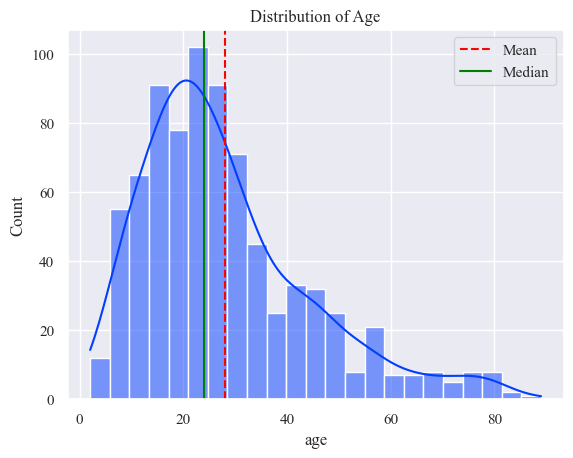

In [77]:
# Histogram for "age"

sns.histplot(df["age"], kde=True)
plt.title("Distribution of Age")

# calculating mean and median
age_mean = df["age"].mean()
age_median = df["age"].median()

print("Mean:", age_mean)
print("Median:", age_median)


# adding vertical lines for mean and median
plt.axvline(age_mean, color="red", linestyle="--", label="Mean")
plt.axvline(age_median, color="green", linestyle="-", label="Median")

plt.legend()

plt.show()

Mean: 8.537303106501248
Median: 9.605299308


C:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


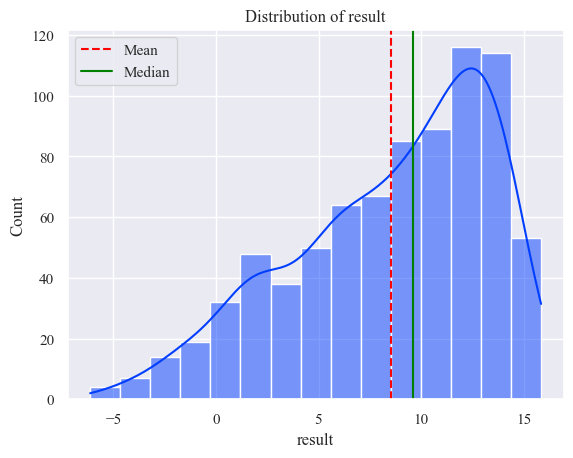

In [78]:
# Histogram for "result"

sns.histplot(df["result"], kde=True)
plt.title("Distribution of result")

# calculating mean and median
result_mean = df["result"].mean()
result_median = df["result"].median()

print("Mean:", result_mean)
print("Median:", result_median)


# adding vertical lines for mean and median
plt.axvline(result_mean, color="red", linestyle="--", label="Mean")
plt.axvline(result_median, color="green", linestyle="-", label="Median")

plt.legend()

plt.show()

## Box plots for identifying outliers in the numerical columns

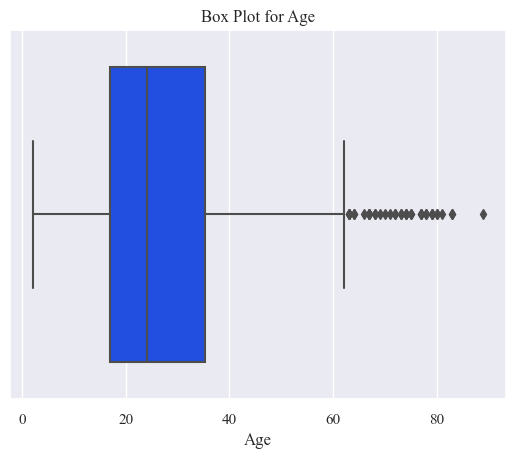

In [80]:
# box plot
sns.boxplot(x=df['age'])
plt.title('Box Plot for Age')
plt.xlabel('Age')
plt.show()

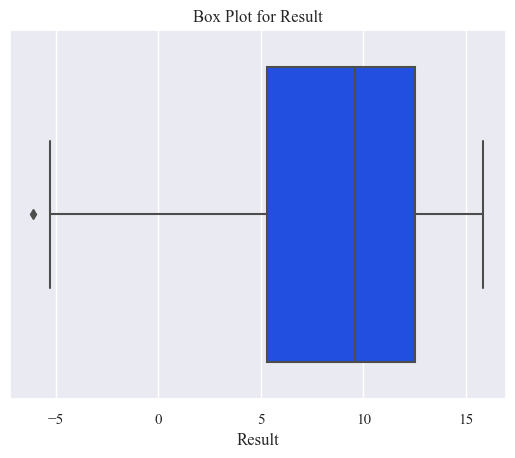

In [81]:
# box plot
sns.boxplot(x=df['result'])
plt.title('Box Plot for Result')
plt.xlabel('Result')
plt.show()

In [82]:
# counting the outliers using IQR method (Age)
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
age_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

In [83]:
len(age_outliers)

39

In [84]:
# counting the outliers using IQR method (Result)
Q1 = df['result'].quantile(0.25)
Q3 = df['result'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
result_outliers = df[(df['result'] < lower_bound) | (df['result'] > upper_bound)]

In [85]:
len(result_outliers)

1

### Univariate analysis of Categorical columns

In [87]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

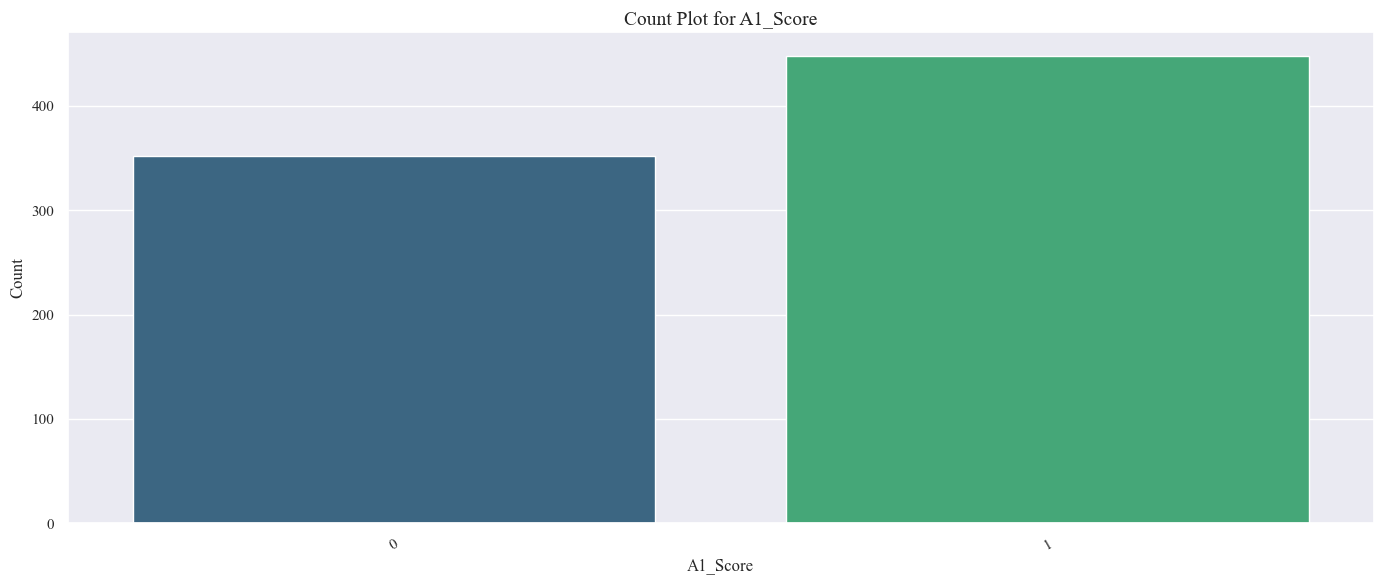

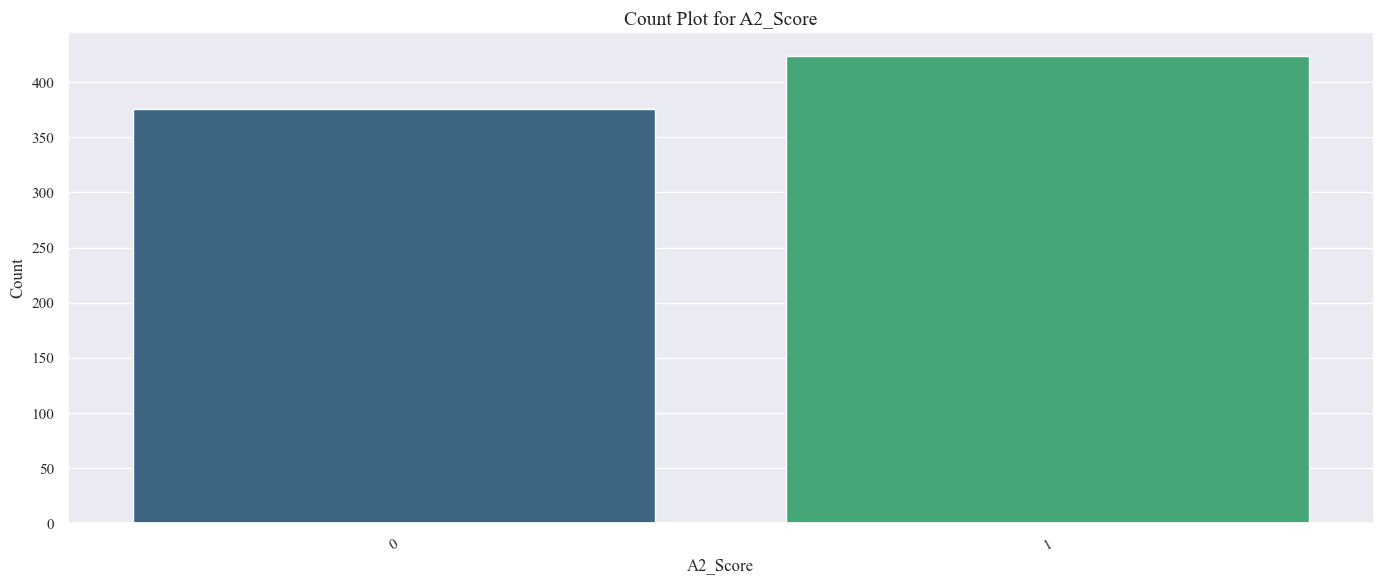

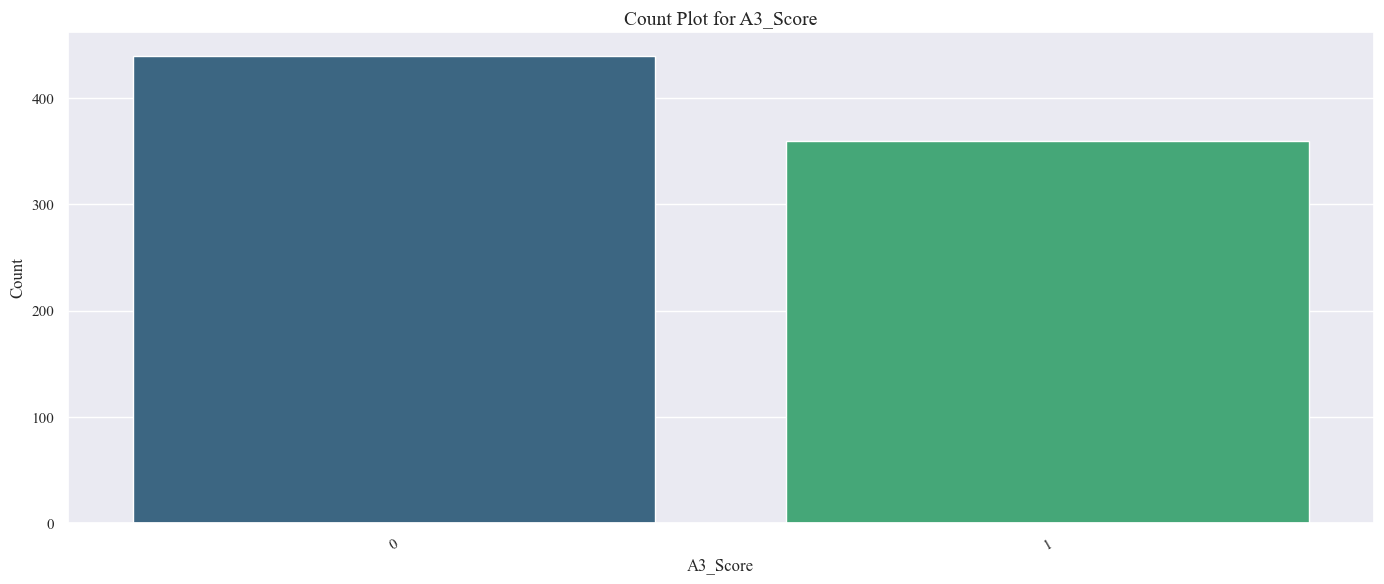

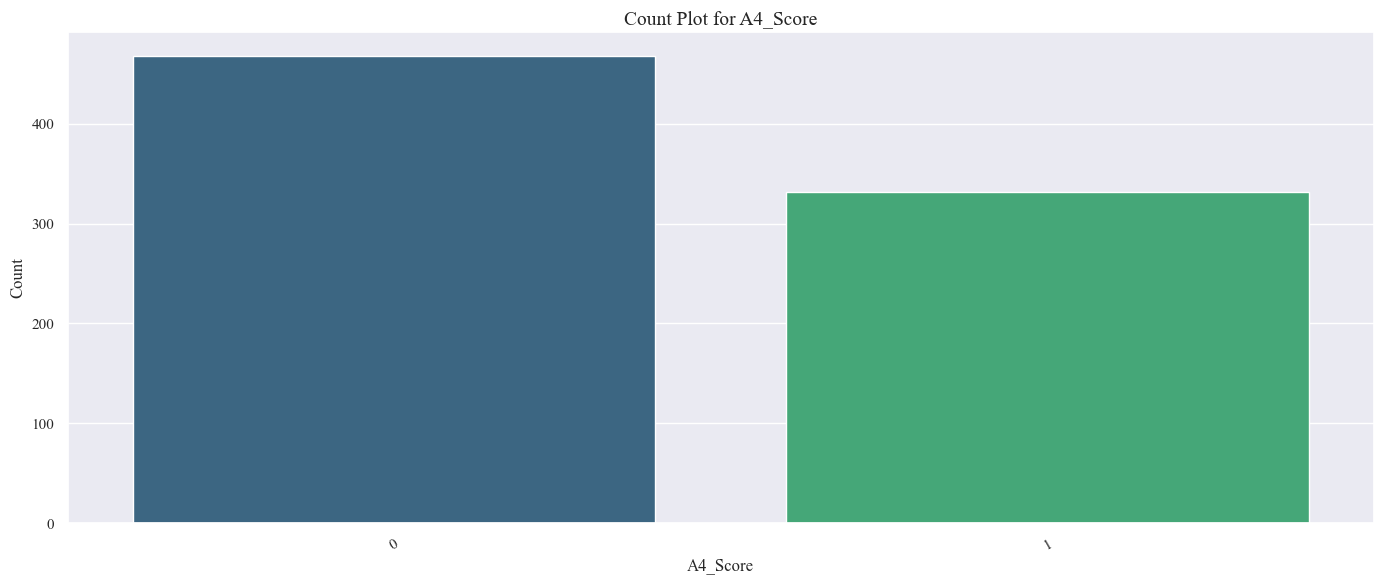

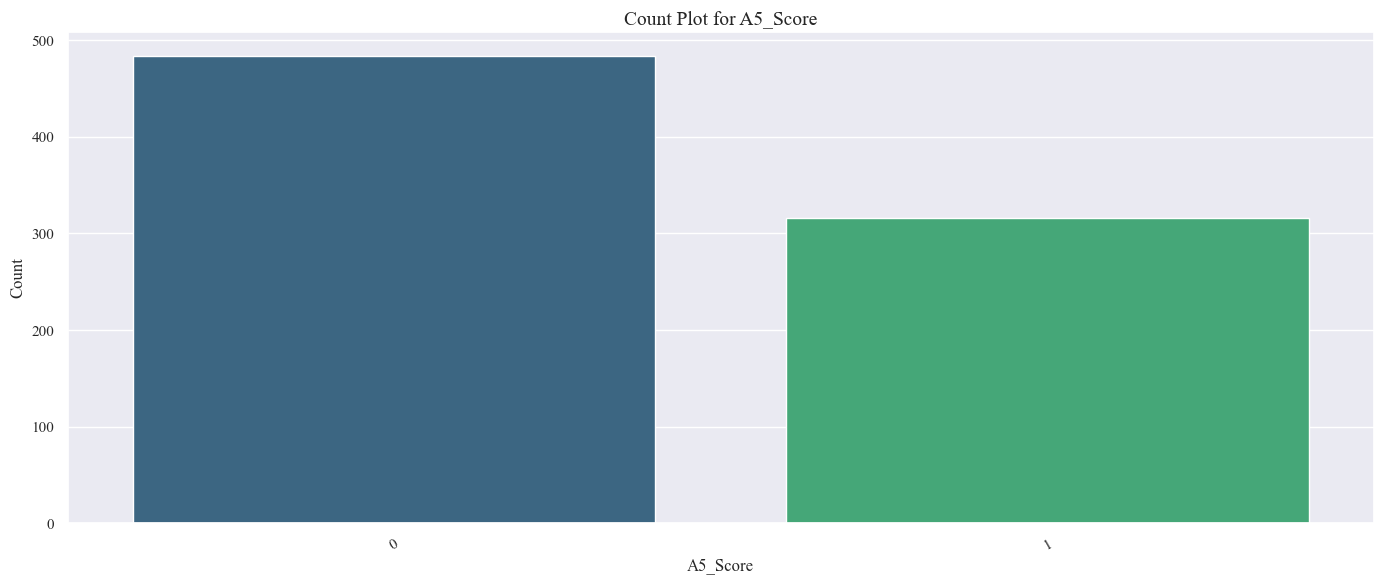

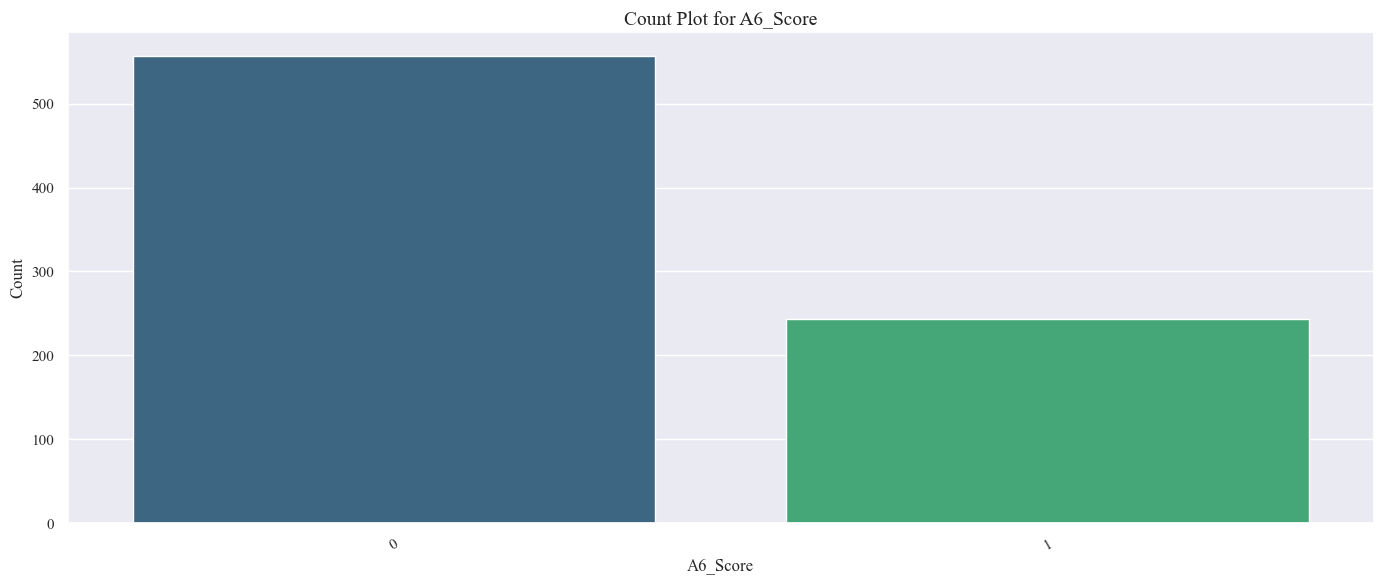

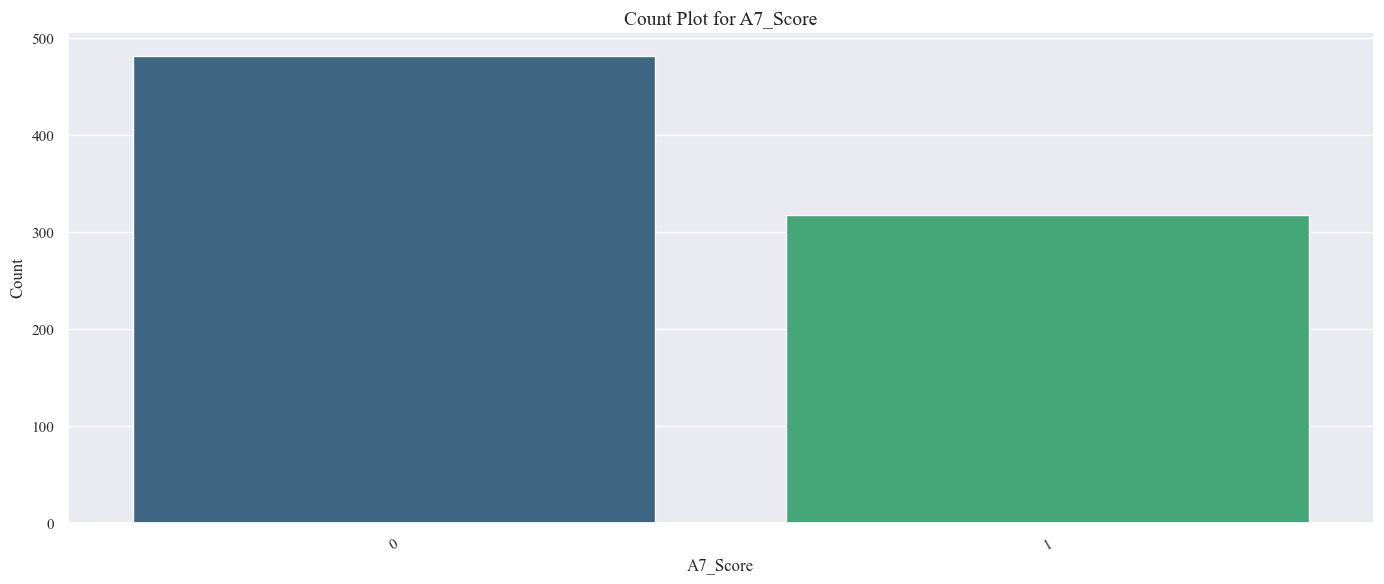

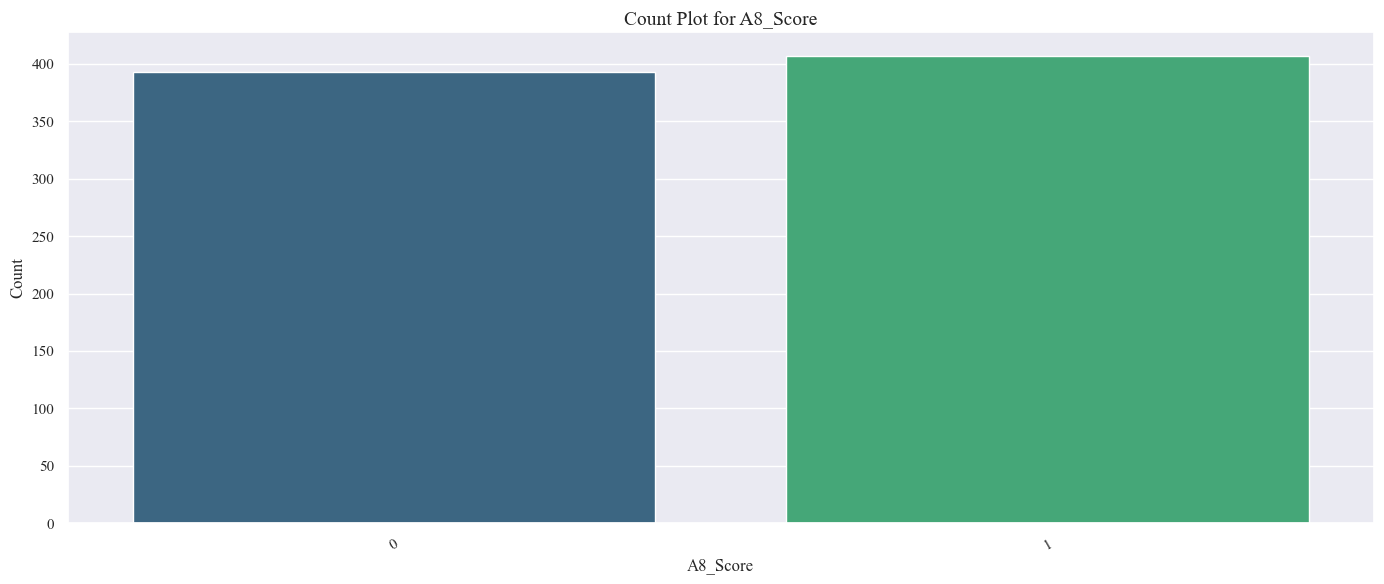

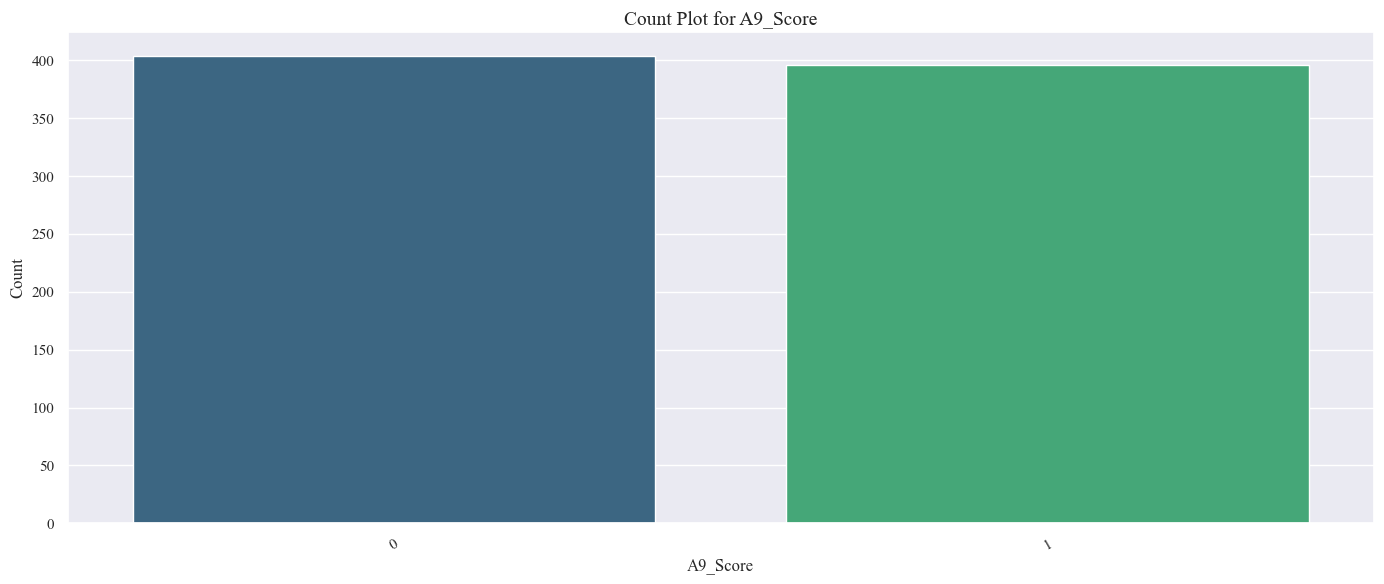

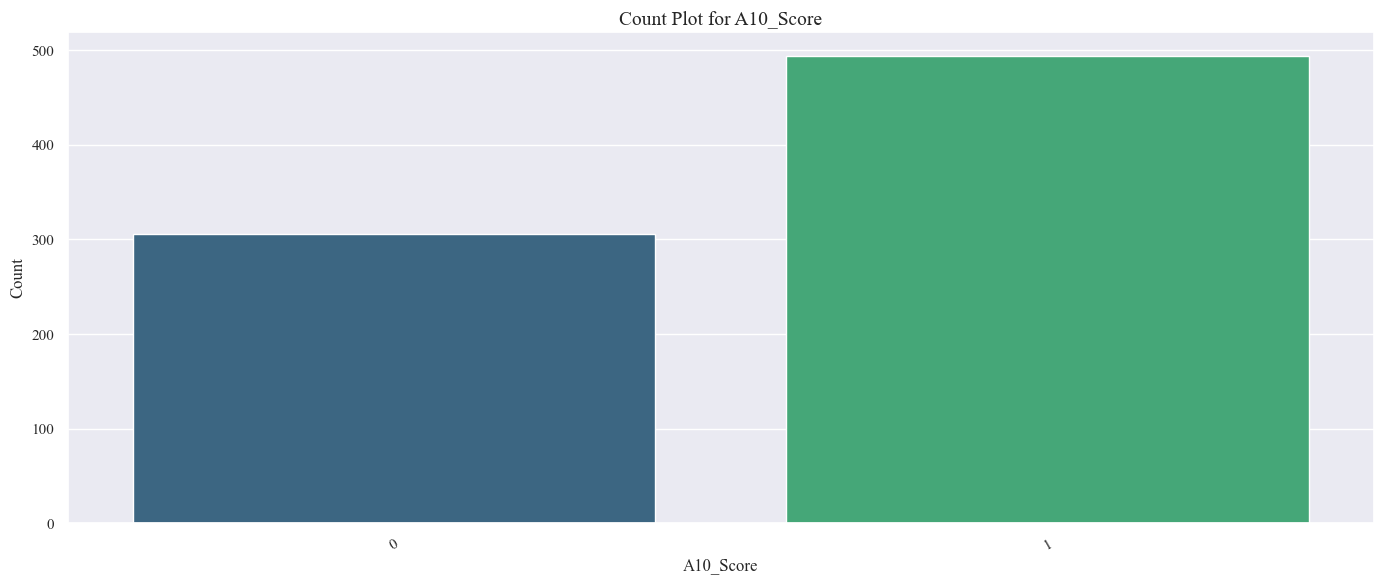

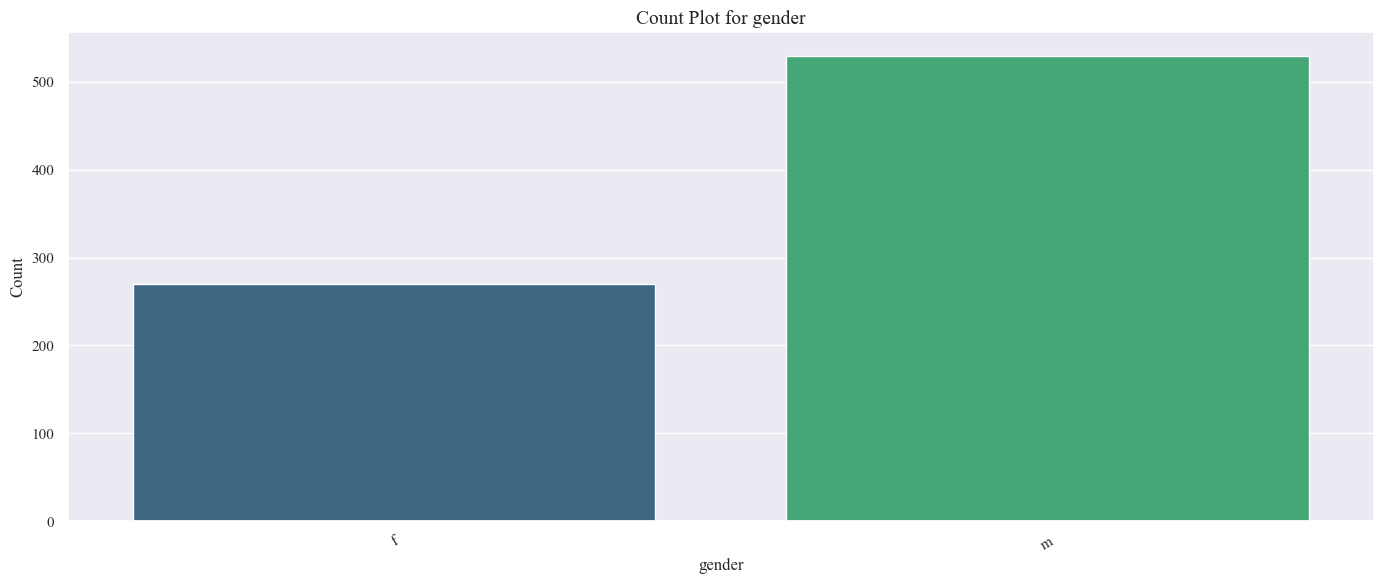

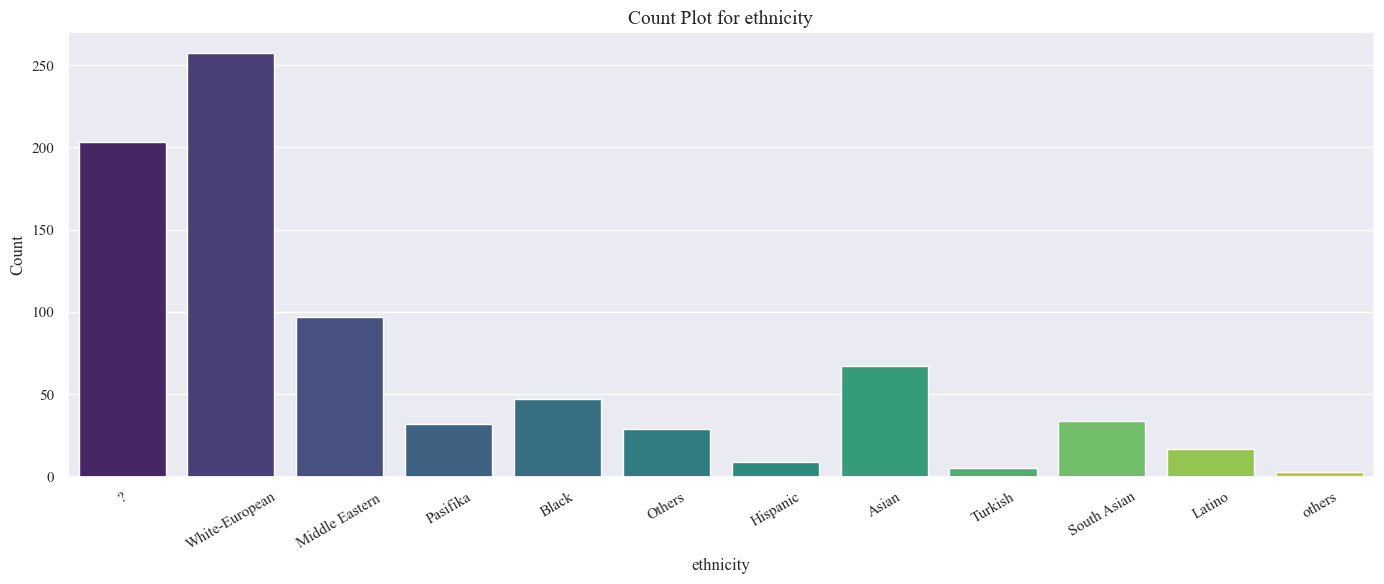

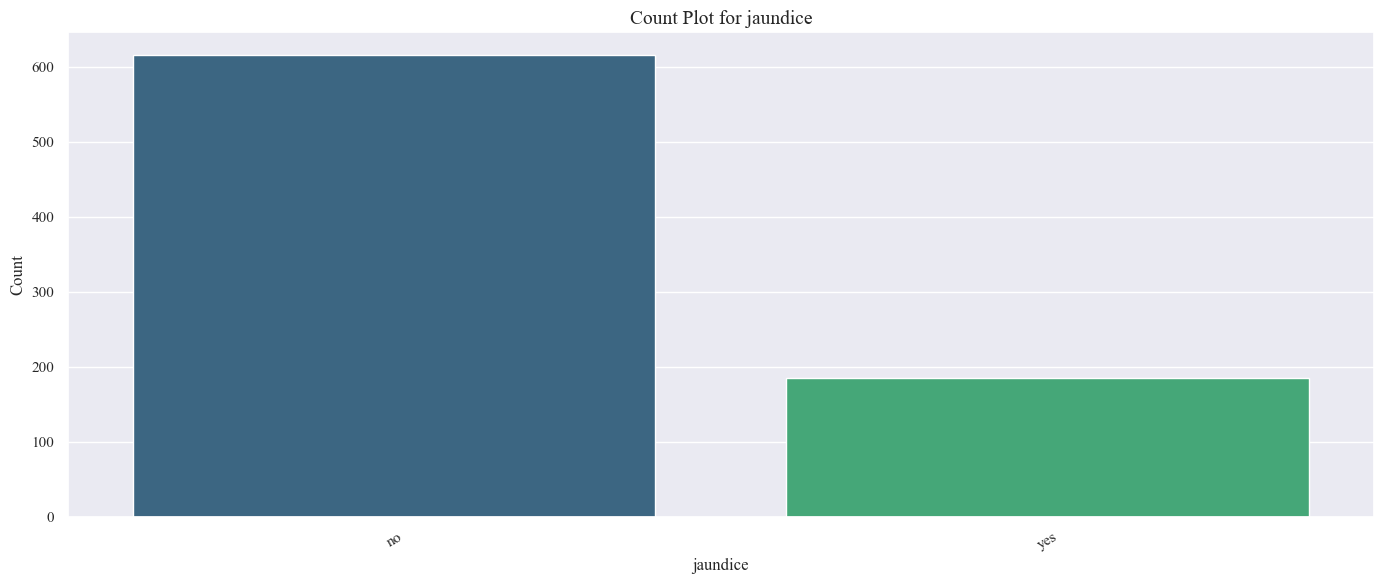

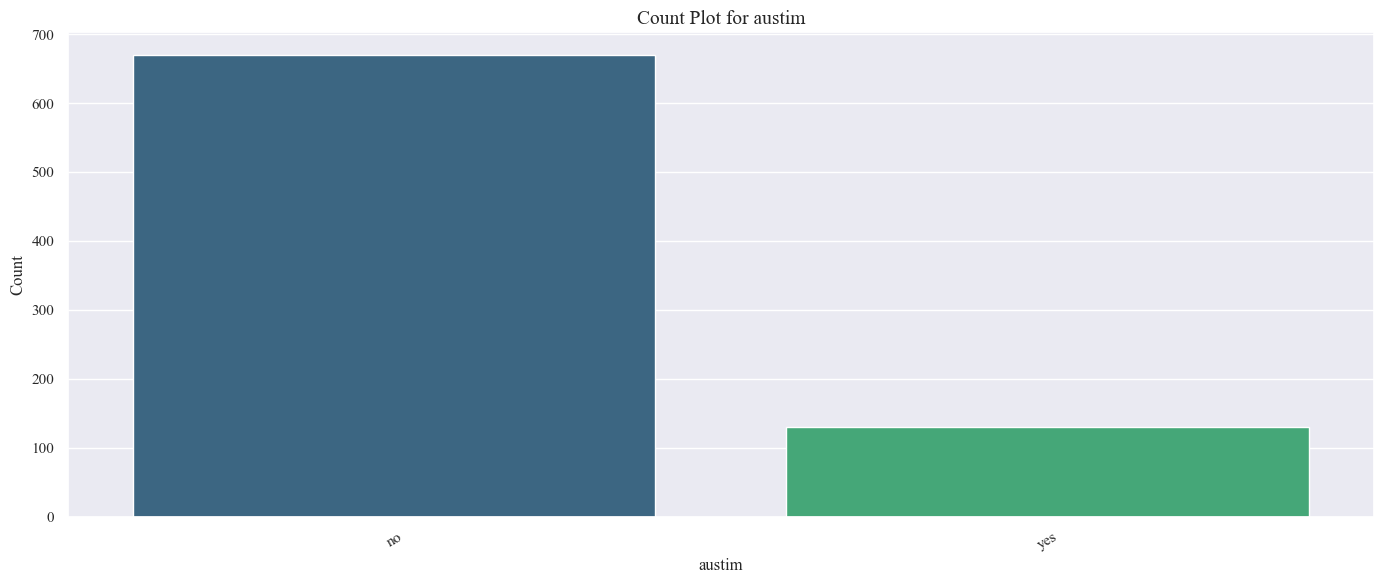

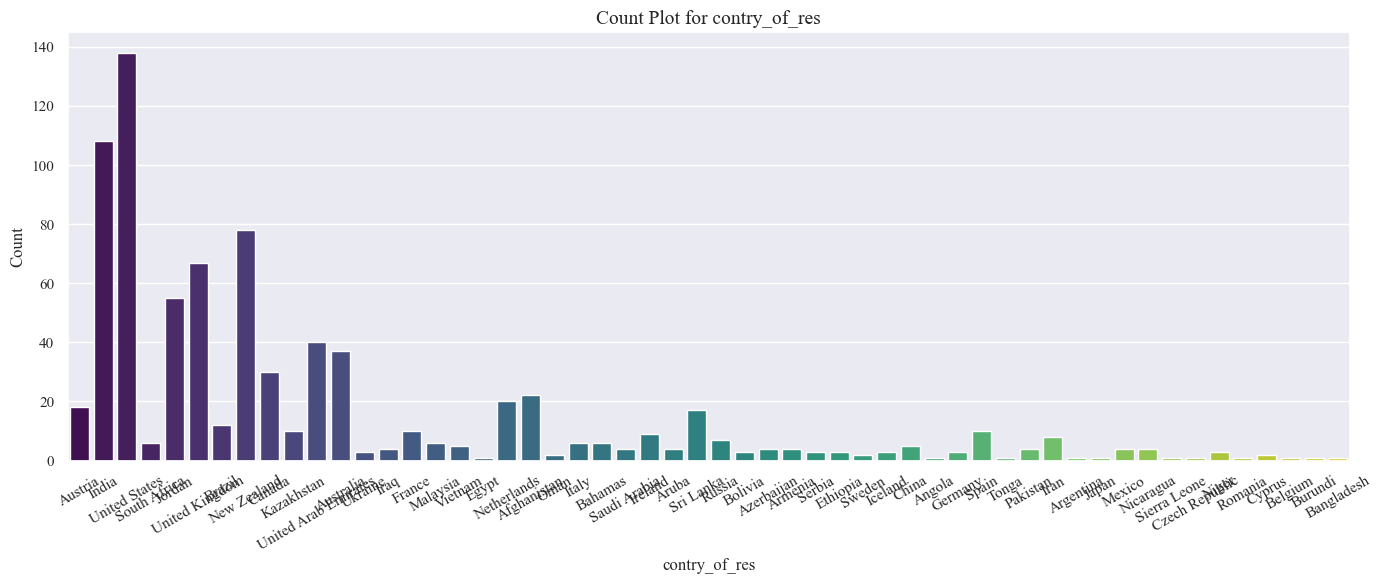

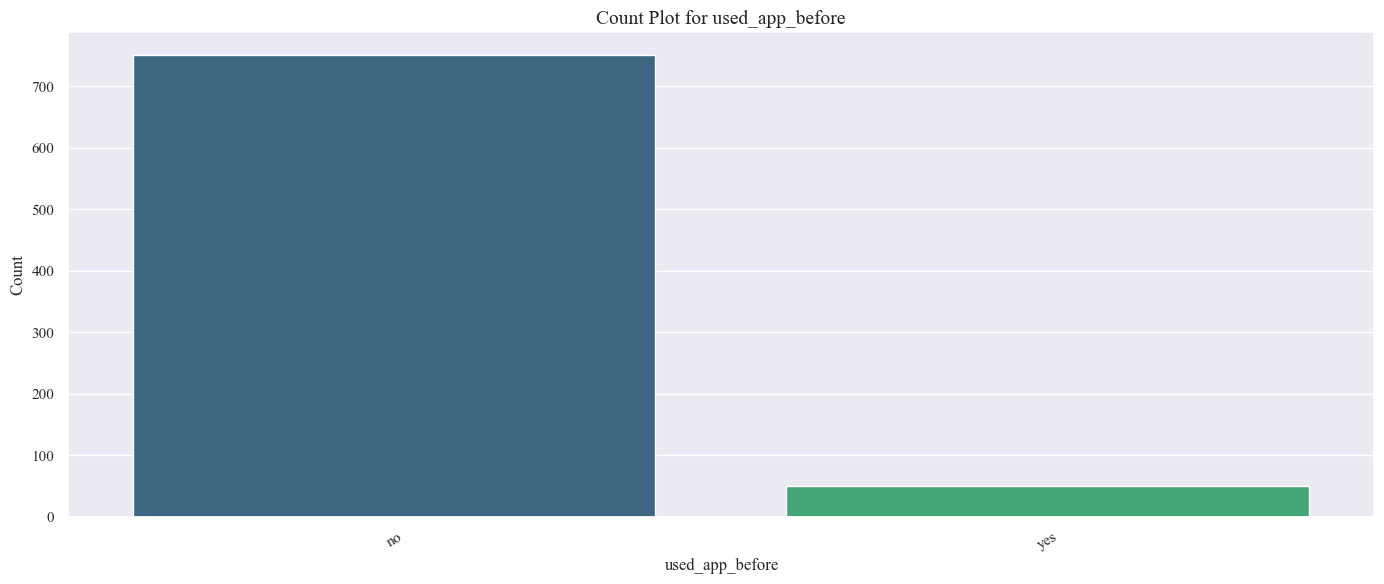

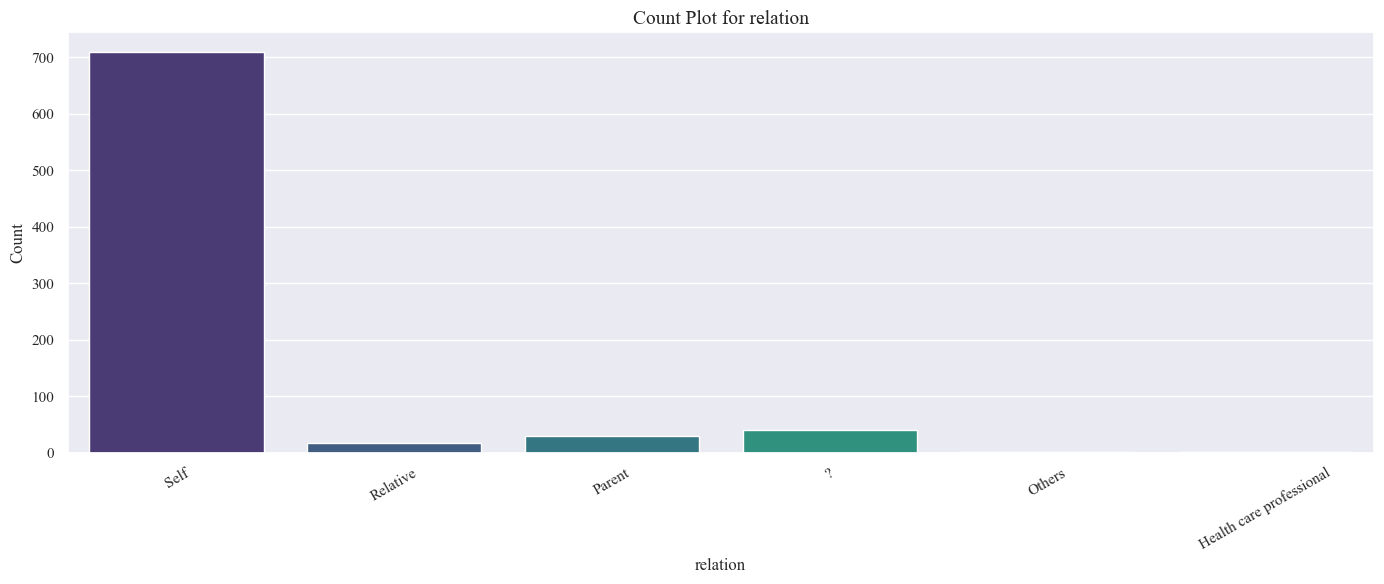

In [88]:
categorical_columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'relation']

for col in categorical_columns:
    plt.figure(figsize=(14, 6)) 
    sns.countplot(x=df[col], palette="viridis") 
    plt.title(f"Count Plot for {col}", fontsize=14) 
    plt.xlabel(col, fontsize=12) 
    plt.ylabel('Count', fontsize=12)  
    plt.xticks(rotation=30)  
    plt.tight_layout()
    plt.show()

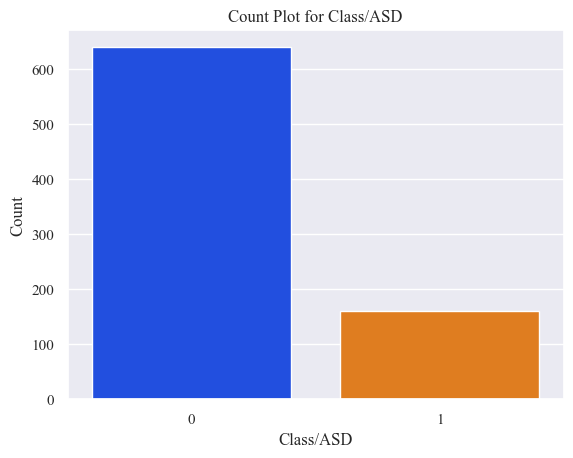

In [89]:
# countplot for target column (Class/ASD)
sns.countplot(x=df["Class/ASD"])
plt.title("Count Plot for Class/ASD")
plt.xlabel("Class/ASD")
plt.ylabel("Count")
plt.show()

In [90]:
df["Class/ASD"].value_counts()

Class/ASD
0    639
1    161
Name: count, dtype: int64

### Handling missing values in ethnicity and relation column

In [92]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})

In [93]:
df["ethnicity"].unique()

array(['Others', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino'],
      dtype=object)

In [94]:
df["relation"].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [95]:
df["relation"] = df["relation"].replace(
    {"?": "Others",
     "Relative": "Others",
     "Parent": "Others",
     "Health care professional": "Others"}
)

In [96]:
df["relation"].unique()

array(['Self', 'Others'], dtype=object)

In [97]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,Others,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,Others,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,Others,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,Others,no,no,South Africa,no,-4.777286,Self,0


## Label Encoding

In [99]:
# identify columns with "object" data type
object_columns = df.select_dtypes(include=["object"]).columns

In [100]:
object_columns

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')

In [101]:
# initializing a dictionary to store the encoders
encoders = {}

# applying label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder   # saving the encoder for this column


# saving the encoders as a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [102]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'austim': LabelEncoder(),
 'contry_of_res': LabelEncoder(),
 'used_app_before': LabelEncoder(),
 'relation': LabelEncoder()}

In [103]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43,1,5,0,0,44,0,-4.777286,1,0


### Bivariate Analysis

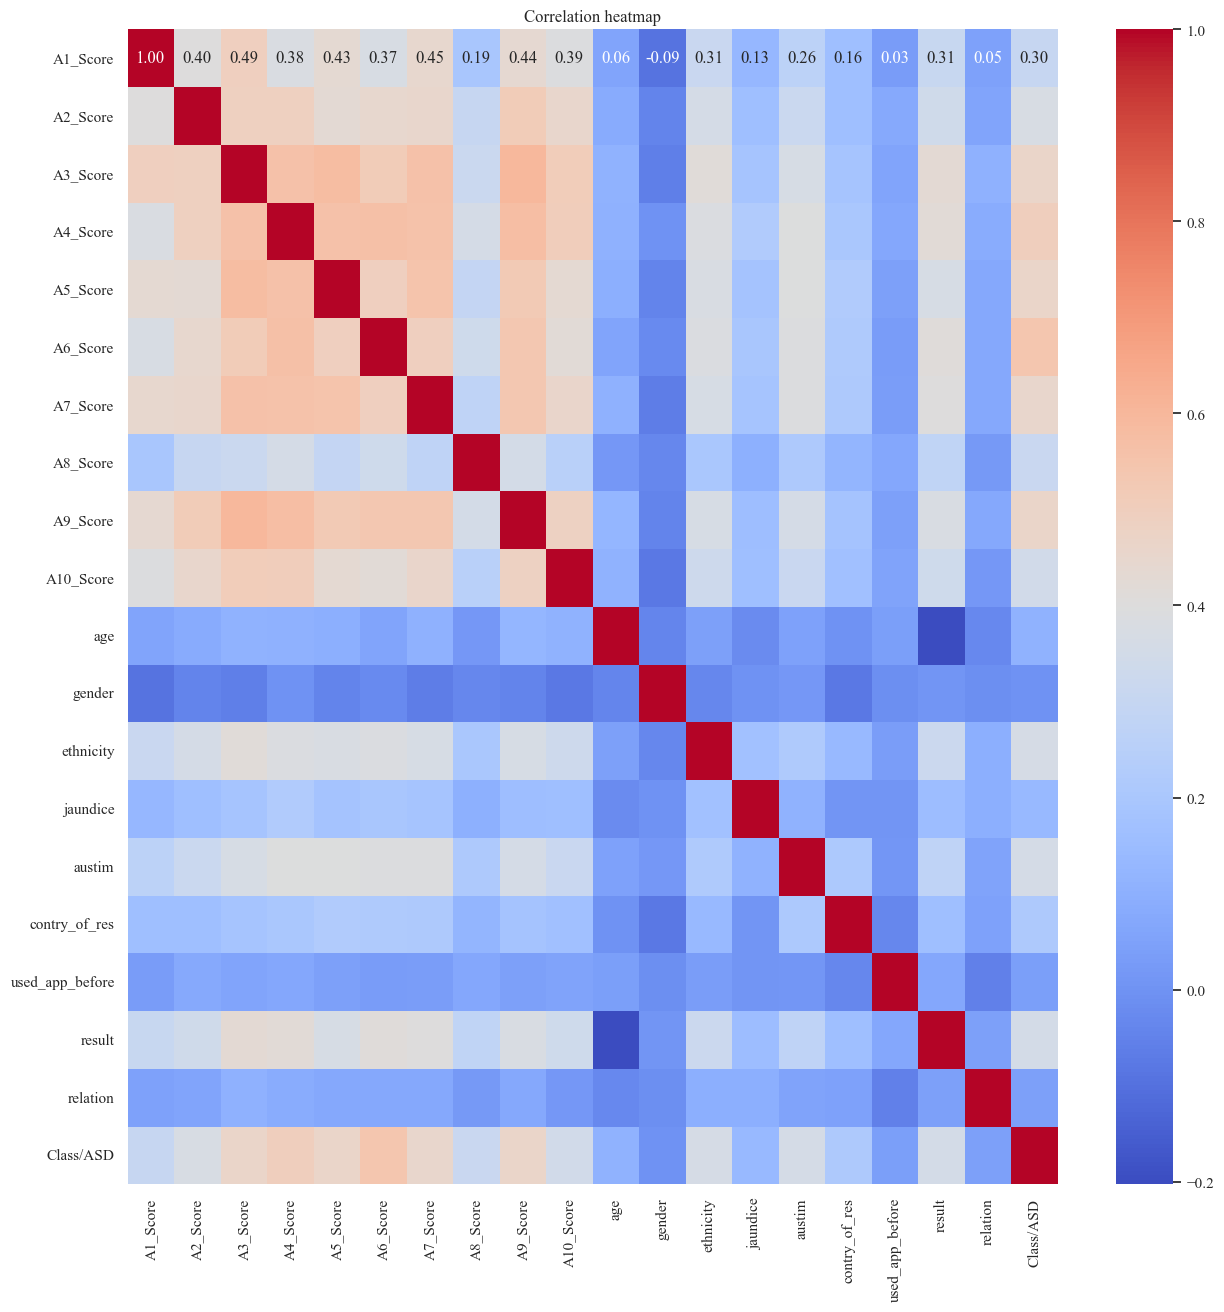

In [105]:
# correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap")
plt.show()

## Insights from EDA:

* There are few outliers in the numerical columns (age, results)
* There is a class imbalance in the target column
* There is a class imbalance in the categorical features
* We don't have any highly correlated column
* performed label encoding and saved the encoders

# 5. Data preprocessing

## Handling the outliers

In [109]:
# function to replace the outliers with median
def replace_outliers_with_median(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  median = df[column].median()

  # replacing outliers with median value
  df[column] = df[column].apply(lambda x: median if x < lower_bound or x > upper_bound else x)

  return df

In [110]:
# replace outliers in the "age" column
df = replace_outliers_with_median(df, "age")

# replace outliers in the "result" column
df = replace_outliers_with_median(df, "result")

In [111]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38.0,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47.0,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7.0,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23.0,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43.0,1,5,0,0,44,0,-4.777286,1,0


In [112]:
df.shape

(800, 20)

## Train Test Split

In [114]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'relation', 'Class/ASD'],
      dtype='object')

In [115]:
X = df.drop(columns=["Class/ASD"])
y = df["Class/ASD"]

In [116]:
X

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation
0,1,0,1,0,1,0,1,0,1,1,38.0,0,5,0,0,6,0,6.351166,1
1,0,0,0,0,0,0,0,0,0,0,47.0,1,5,0,0,23,0,2.255185,1
2,1,1,1,1,1,1,1,1,1,1,7.0,1,9,0,1,52,0,14.851484,1
3,0,0,0,0,0,0,0,0,0,0,23.0,0,5,0,0,52,0,2.276617,1
4,0,0,0,0,0,0,0,0,0,0,43.0,1,5,0,0,44,0,-4.777286,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,1,0,0,0,0,0,0,1,1,16.0,1,2,0,0,34,0,12.999501,1
796,0,1,1,0,0,1,0,1,1,1,20.0,1,9,0,0,16,0,13.561518,1
797,0,0,0,0,0,0,0,0,0,0,5.0,1,7,1,0,34,0,2.653177,1
798,0,0,0,0,0,0,0,0,0,0,16.0,0,5,0,0,14,0,9.069342,1


In [117]:
y

0      0
1      0
2      1
3      0
4      0
      ..
795    0
796    0
797    0
798    0
799    0
Name: Class/ASD, Length: 800, dtype: int64

In [118]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [119]:
y_train.shape

(640,)

In [120]:
y_test.shape

(160,)

In [121]:
y_train.value_counts()

Class/ASD
0    515
1    125
Name: count, dtype: int64

In [122]:
y_test.value_counts()

Class/ASD
0    124
1     36
Name: count, dtype: int64

## SMOTE (Synthetic Minority Oversampling technique)

In [124]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [125]:
y_train_smote.shape

(1030,)

In [126]:
y_train_smote.value_counts()

Class/ASD
1    515
0    515
Name: count, dtype: int64

In [127]:
# Convert to numpy arrays for our implementation
X_train_np = X_train_smote.values
y_train_np = y_train_smote.values
X_test_np = X_test.values

# 6. Model Training

In [129]:
# Initialize RandomForest with a fixed random seed
rf = RandomForest(n_trees=50, max_depth=10, min_samples_split=2, random_state=42)
rf.fit(X_train_np, y_train_np)


## 7. Evaluation

In [131]:
# Evaluation
y_pred = rf.predict(X_test_np)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8375
Confusion Matrix:
 [[107  17]
 [  9  27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       124
           1       0.61      0.75      0.67        36

    accuracy                           0.84       160
   macro avg       0.77      0.81      0.78       160
weighted avg       0.85      0.84      0.84       160



In [132]:
# Save model
with open("custom_rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)